# 2022-09-20 analysis

We see longitudinal and transverse hollowing in our measurements at slit HZ04, 1.4 meters downstream of the RFQ. This notebook explores the dependence of these features on space charge. The initial bunch was generated from an RFQ simulation described [here](https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.124201). The current was 42 mA at the RFQ exit; the current was artificially lowered in the following simulations.

In [19]:
import sys
import os
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from pprint import pprint
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import proplot as pplt
from ipywidgets import widgets
from ipywidgets import interactive

sys.path.append('/Users/46h/Research/')
from btfsim.analysis.utils import load_bunch
from btfsim.analysis.utils import load_history
from beamphys import plotting as mplt
from beamphys import utils
from beamphys import dist as bd
from beamphys import image as bi
from beamphys import ap

## Settings

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['savefig.dpi'] = 300
# pplt.rc['pdf.fonttype'] = 42

In [3]:
folder = '/Users/46h/Dropbox (ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_current/'
os.listdir(folder)

['.DS_Store',
 '50mA',
 '26mA',
 '22mA',
 '42mA',
 'run_btf.py',
 'figures',
 'README.txt',
 '.ipynb_checkpoints',
 '0mA',
 'analysis.ipynb',
 '34mA']

In [4]:
fig_path = os.path.join(folder, 'figures')
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)

In [5]:
def save(figname):
    """Save figure."""
    plt.savefig(os.path.join(fig_path, f'{figname}.png'))
    return

## Load data

In [6]:
currents = [0, 26, 50]
currents_str = [f'{c}mA' for c in currents]

In [7]:
filenames = dict()
for current in currents_str:
    filenames[current] = dict()
    _folder = os.path.join(folder, current)
    for _filename in os.listdir(_folder):
        if _filename.endswith('.py'):
            continue
        if _filename.split('.dat')[0].endswith('history'):
            filenames[current]['history'] = os.path.join(_folder, _filename)
        elif 'bunch' in _filename:
            node = _filename.split('.dat')[0].split('bunch-')[-1]
            if node.startswith('MEBT:'):
                node = node.split('MEBT:')[-1]
            filenames[current][node] = os.path.join(_folder, _filename)
        else:
            pass
        
print('filenames:')
pprint(filenames)

filenames:
{'0mA': {'HZ04': '/Users/46h/Dropbox '
                 '(ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_current/0mA/220920172739-run_btf-0-HZ04-bunch-HZ04.dat',
         'QH01': '/Users/46h/Dropbox '
                 '(ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_current/0mA/220920172739-run_btf-0-HZ04-bunch-MEBT:QH01.dat',
         'QH03': '/Users/46h/Dropbox '
                 '(ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_current/0mA/220920172739-run_btf-0-HZ04-bunch-MEBT:QH03.dat',
         'QV02': '/Users/46h/Dropbox '
                 '(ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_current/0mA/220920172739-run_btf-0-HZ04-bunch-MEBT:QV02.dat',
         'QV04': '/Users/46h/Dropbox '
                 '(ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_current/0mA/220920172739-run_btf-0-HZ04-bunch-MEBT:QV04.dat',
         'history': '/Users/46h/Dropbox '
                    '(ORNL)/work/btf/btf-sim/2022-09-20_RFQbunch_MEBT1_vary_curren

## History 

In [8]:
fig_kws = dict(
    ncols=len(filenames),
    figwidth=(6.0 / 3.0) * len(currents),
    figheight=2.25,
)
plot_kws = dict(marker='.', ms=1, lw=0, alpha=1.0)

In [9]:
pprint(sorted(load_history(filenames[currents_str[0]]['history']).columns))

['alpha_x',
 'alpha_y',
 'alpha_z',
 'beta_x',
 'beta_y',
 'beta_z',
 'disp_x',
 'dispp_x',
 'eps_x',
 'eps_y',
 'eps_z',
 'nlost',
 'node',
 'nparts',
 'r90',
 'r99',
 's',
 'sig_00',
 'sig_01',
 'sig_02',
 'sig_03',
 'sig_04',
 'sig_05',
 'sig_11',
 'sig_12',
 'sig_13',
 'sig_14',
 'sig_15',
 'sig_22',
 'sig_23',
 'sig_24',
 'sig_25',
 'sig_33',
 'sig_34',
 'sig_35',
 'sig_44',
 'sig_45',
 'sig_55']


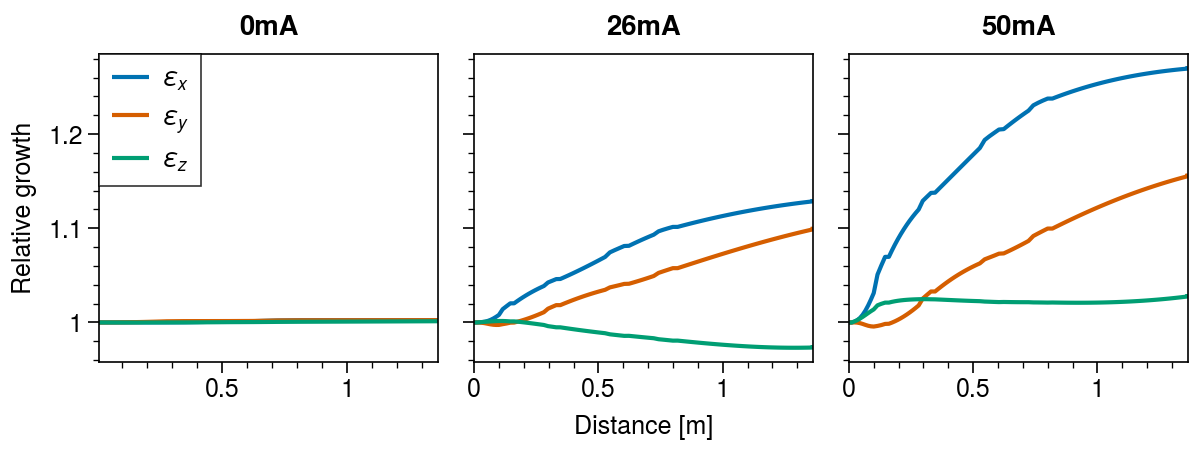

In [10]:
fig, axes = pplt.subplots(**fig_kws)
for ax, current in zip(axes, currents_str):
    history = load_history(filenames[current]['history'])
    for dim in ['x', 'y', 'z']:
        data = history[f'eps_{dim}'].values
        ax.plot(history['s'], data / data[0], label=r'$\varepsilon_{}$'.format(dim))
axes[0].legend(ncol=1, loc='upper left', ms=3, handlelength=1.5)
axes.format(xlabel='Distance [m]', ylabel='Relative growth', toplabels=currents_str)
save('relative_rms_emittance_growth')
plt.show()

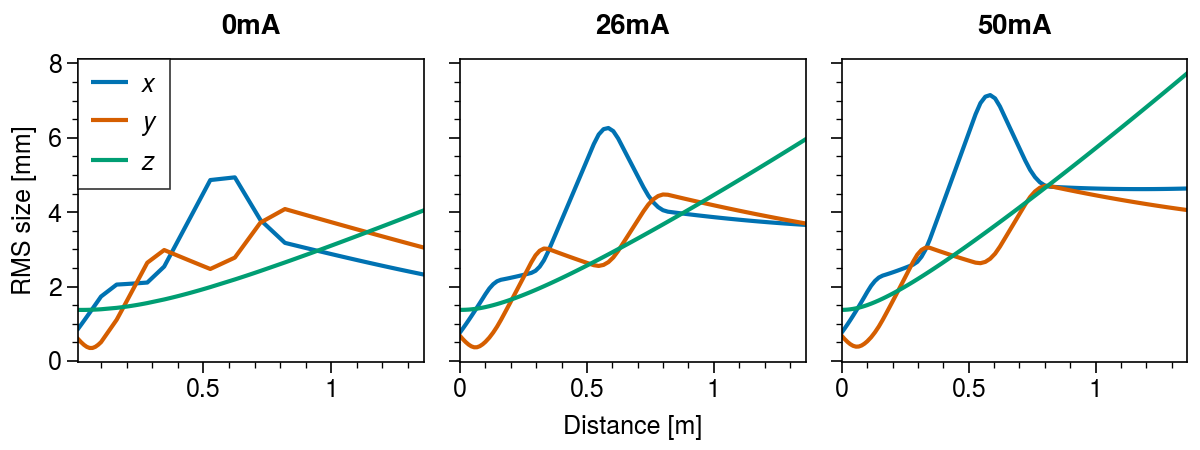

In [11]:
fig, axes = pplt.subplots(**fig_kws)
for ax, current in zip(axes, currents_str):
    history = load_history(filenames[current]['history'])
    for i, dim in enumerate(['x', 'y', 'z']):
        i *= 2
        col = f'sig_{i}{i}'
        data = np.sqrt(history[col].values)
        data *= 1e3  # convert [m] to [mm]
        ax.plot(history['s'], data, label=r'${}$'.format(dim))
axes[0].legend(ncol=1, loc='upper left', handlelength=1.5)
axes.format(xlabel='Distance [m]', ylabel='RMS size [mm]', toplabels=currents_str)
save('rms_beam_size')
plt.show()

## Bunch 

In [12]:
dims = ["x", "x'", "y", "y'", "z", "dE"]
units = ["mm", "mrad", "mm", "mrad", "mm", "keV"]
labels = [f'{d} [{u}]' for d, u in zip(dims, units)]
nodes = ['init', 'QH01', 'QV02', 'QH03', 'QV04', 'HZ04']

### Interactive 

In [13]:
plot_kws = dict(
    prof_kws=dict(lw=0.8, alpha=0.4, color='white'),
    mask_zero=False,
)
int_kws = dict(
    dims=dims,
    units=units,
    nbins=40,
    **plot_kws
)

In [15]:
node = 'HZ04'
for current in currents_str[-1:]:
    print(f'current = {current}')
    gui = mplt.interactive_proj2d_discrete(
        load_bunch(filenames[current][node]),
        **int_kws
    )
    display(gui)

current = 50mA


interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=False, description='profiles'),…

### x-z partial projections

View the x-z projection of the distribution sliced in y, y', x'. Normalize to unit variance in all dimensions.

In [16]:
for current in currents_str:
    for node in nodes:
        # Load the bunch and normalize the coordinates.
        X = np.copy(load_bunch(filenames[current][node]))
        Sigma = np.cov(X.T)
        X = X / np.sqrt(Sigma.diagonal())
        maxs = np.max(X, axis=0)
        
        # Compute the slice width.
        bins = 40
        edges = [np.histogram_bin_edges(X[:, i], bins=bins) for i in range(X.shape[1])]
        dx = [np.diff(e)[0] for e in edges]
        
        # Plot
        fig, axes = pplt.subplots(ncols=2, nrows=2,  figwidth=4.0)
        axes.format(
            xlim=(-maxs[0], maxs[0]), 
            ylim=(-maxs[4], maxs[4]),
        )
        for ax, islice in zip(axes, [None, (2,), (2, 3), (2, 3, 1)]):
            if islice is None:
                _X = X
            else:
                _limits = [(-dx[i], dx[i]) for i in islice]
                _X = bd.slice_box(X, axis=islice, limits=_limits)
            _im, _edges = np.histogramdd(_X[:, (0, 4)], bins, ((-maxs[0], maxs[0]), (-maxs[4], maxs[4])))
            _centers = [utils.get_bin_centers(e) for e in _edges]
            mplt.plot_image(_im, x=_centers[0], y=_centers[1], ax=ax)
            if islice is None:
                continue
            dims_n = [r"{}$_n$".format(dim) for dim in dims]
            text = r'$\approx$'.join([dims_n[i] for i in islice]) + r'$\approx 0$'
            ax.annotate(text, xy=(0.02, 0.98), xycoords='axes fraction', verticalalignment='top',
                        color='white')
        axes.format(xlabel=r'x$_n$', ylabel=r'z$_n$')
        save('x-z_slices_{}_{}_norm'.format(current, node))

### x-y-z 

#### Investigation of phase advances...

What about projections at a different angle in x-x' and y-y'? I know that the hollow x projection is due to nonlinear tails — "s" shape — in the x-x' phase space, but the x-x' distribution is rotated at different angles at different points along the beamline. What if we project onto the u and v axes, where $(u, u')^T = R (x, x')^T$ and $(v, v')^T = R (y, y')^T$?

In [17]:
current = '50mA'
node = 'HZ04'
X = load_bunch(filenames[current][node])

First normalize the x-x' and y-y' phase space.

In [20]:
Sigma = np.cov(X.T)
twiss_params = ap.twiss(Sigma)
emittances = ap.apparent_emittances(Sigma)

V = ap.norm_mat(*twiss_params)
A = np.sqrt(np.diag(np.repeat(emittances, 2)))
T = np.matmul(A, V)
Vinv = np.linalg.inv(V)
Ainv = np.linalg.inv(A)
Tinv = np.linalg.inv(T)

In [22]:
Xn = utils.apply(Tinv, X)

Rotate the normalized x-x' and y-y' (near z=0) and look at the projections.

In [ ]:
# mux = np.radians(12.0)
# muy = np.radians(0.0)
# P = ap.phase_adv_mat(mux, muy)
# Yn = Xn.copy()
# Yn[:, :4] = utils.apply(P, Yn[:, :4])
# mplt.interactive_proj2d_discrete(Yn, nbins=40, dims=["u", "u'", "v", "v'", "z_n", "dE_n"])

In [25]:
Xn_zslice = bd.slice_box(Xn, axis=4, limits=(-0.1, 0.1))

ncols = 8
muxx = np.radians(np.linspace(0.0, 45.0, 8))
axis_view = (0, 2)
dims_u = ["x", "x'", "y", "y'", "z", "dE"]
maxs = [3.5, 5.0, 3.5, 5.0]

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=ncols, figwidth=8.5, span=False)
axes.format(xticks=[], yticks=[])
for j, mux in enumerate(muxx):
    Yn = Xn_zslice.copy()
    Yn[:, :2] = utils.apply(ap.rotation_mat(mux), Yn[:, :2])
    for i, axis_view in enumerate([(0, 1), (0, 2)]):
        ax = axes[i, j]
        image, centers = bd.histogram(
            Yn[:, axis_view], bins=75,
            binrange=[
                (-maxs[axis_view[0]], maxs[axis_view[0]]),
                (-maxs[axis_view[1]], maxs[axis_view[1]]),
            ], 
            centers=True,
        )
        mplt.plot_image(
            image, 
            x=centers[0], 
            y=centers[1], 
            ax=ax,
            profx=True, profy=True, prof_kws=dict(lw=0.65, alpha=0.7, kind='line'),
        )
        axes[i, :].format(xlabel=dims_u[axis_view[0]], ylabel=dims_u[axis_view[1]])
    axes[0, j].format(title=r"$\mu_x = {:.2f}\degree$".format(np.degrees(mux)))
save(f'norm_xxp_rotation_{current}_{node}')
plt.show()

In [ ]:
muyy = np.radians(np.linspace(0.0, 45.0, 8))
axis_view = (0, 2)
dims_u = ["x", "x'", "y", "y'", "z", "dE"]
maxs = [3.5, 5.0, 3.5, 5.0]

fig, axes = pplt.subplots(nrows=2, ncols=ncols, figwidth=8.5, span=False)
axes.format(xticks=[], yticks=[])
for j, muy in enumerate(muyy):
    Yn = Xn_zslice.copy()
    Yn[:, 2:4] = utils.apply(ap.rotation_mat(muy), Yn[:, 2:4])
    for i, axis_view in enumerate([(2, 3), (2, 0)]):
        ax = axes[i, j]
        image, centers = bd.histogram(
            Yn[:, axis_view], bins=75,
            binrange=[
                (-maxs[axis_view[0]], maxs[axis_view[0]]),
                (-maxs[axis_view[1]], maxs[axis_view[1]]),
            ], 
            centers=True,
        )
        mplt.plot_image(
            image, 
            x=centers[0], 
            y=centers[1], 
            ax=ax,
            profx=True, profy=True, prof_kws=dict(lw=0.65, alpha=0.7, kind='line'),
        )
        axes[i, :].format(xlabel=dims_u[axis_view[0]], ylabel=dims_u[axis_view[1]])
    axes[0, j].format(title=r"$\mu_y = {:.2f}\degree$".format(np.degrees(muy)))
save(f'norm_yyp_rotation_{current}_{node}')
plt.show()

#### 4D phase space at z=0 

In [99]:
Xn_zslice = bd.slice_box(Xn, axis=4, limits=(-0.3, 0.3))
Xn_zslice.shape

(1818532, 6)

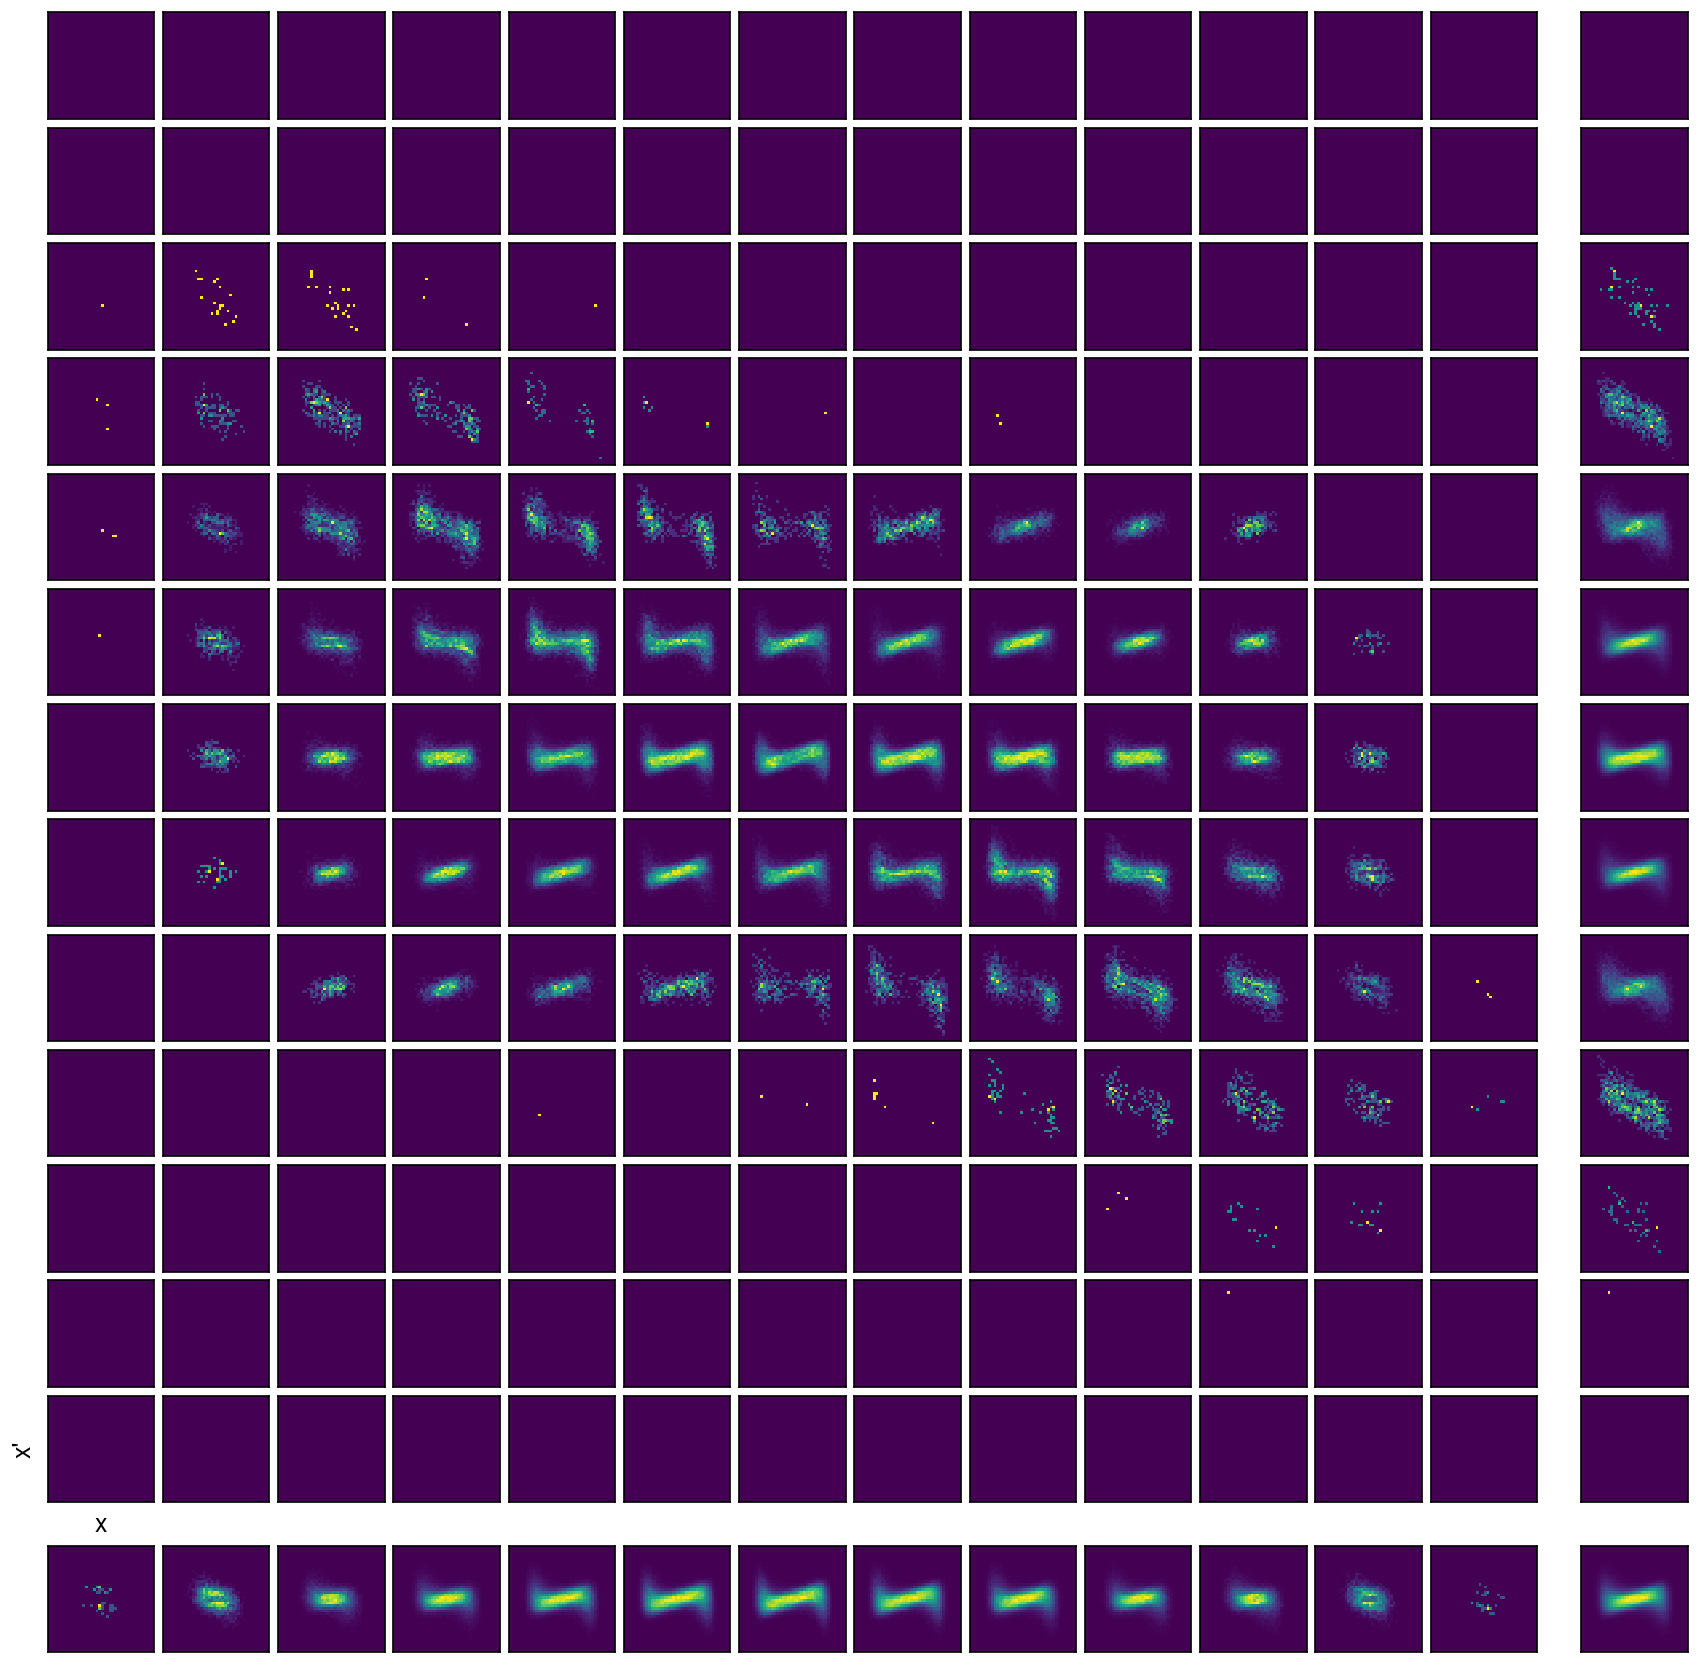

In [111]:
axis_view = (0, 1)
axis_slice = (2, 3)
n = 13
slice_width = 5.0/n  # transverse slice width in normalized coordinates

limits = mplt.auto_limits(Xn_zslice, zero_center=True)
nrows = ncols = n
pads = [0. * max(lim) for lim in limits]
coords = [np.linspace(umin + pad, umax - pad, n) for (umin, umax), pad in zip(limits, pads)]

plot_kws = dict(
    # profx=True, profy=True, prof_kws=dict(lw=0.4, alpha=0.5, kind='line'),
)

space = 0.35
hspace = nrows * [space]
wspace = ncols * [space]
hspace[-1] = wspace[-1] = 5.0 * space
fig, axes = pplt.subplots(
    ncols=ncols+1, nrows=nrows+1, figwidth=8.5,
    hspace=hspace, wspace=wspace,
    share=False,
    xticks=[], yticks=[],
)
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        center = [coords[axis_slice[0]][j], coords[axis_slice[1]][~i]]
        XXP = bd.slice_box(
            Xn_zslice, axis=axis_slice,
            limits=[
                (center[0] - 0.5 * slice_width, center[0] + 0.5 * slice_width),
                (center[1] - 0.5 * slice_width, center[1] + 0.5 * slice_width),
            ]
        )
        image, centers = bd.histogram(XXP[:, (0, 1)], bins=40, binrange=limits[:2], centers=True)
        mplt.plot_image(
            image,
            x=centers[0],
            y=centers[1],
            ax=ax,
            vmax=None,
            **plot_kws
        )
for i, ax in enumerate(axes[:-1, -1]):
    center = coords[axis_slice[1]][~i]
    XXP = bd.slice_box(
        Xn_zslice, axis=3, 
        limits=(center - 0.5 * slice_width, center + 0.5 * slice_width)
    )
    image, centers = bd.histogram(XXP[:, (0, 1)], bins=40, binrange=limits[:2], centers=True)
    mplt.plot_image(
        image,
        x=centers[0],
        y=centers[1],
        ax=ax,
        vmax=None,
        **plot_kws
    )
for i, ax in enumerate(axes[-1, :-1]):
    center = coords[axis_slice[0]][i]
    XXP = bd.slice_box(
        Xn_zslice, axis=2, 
        limits=(center - 0.5 * slice_width, center + 0.5 * slice_width)
    )
    image, centers = bd.histogram(XXP[:, (0, 1)], bins=40, binrange=limits[:2], centers=True)
    mplt.plot_image(
        image,
        x=centers[0],
        y=centers[1],
        ax=ax,
        vmax=None,
        **plot_kws
    )

XXP = Xn_zslice
image, centers = bd.histogram(XXP[:, (0, 1)], bins=40, binrange=limits[:2], centers=True)
mplt.plot_image(
    image,
    x=centers[0],
    y=centers[1],
    ax=axes[-1, -1],
    vmax=None,
    **plot_kws
)
axes[-2, 0].format(xlabel="x", ylabel="x'")
save(f"x-x'-{axis_slice[0]}-{axis_slice[1]}_zslice{current}_{node}")
plt.show()

#### More plots

Eh, why not load everything into memory. Can change if it's too much.

In [ ]:
coords = dict()
for current in tqdm(currents_str):
    coords[current] = dict()
    for node in tqdm(nodes):
        coords[current][node] = np.copy(load_bunch(filenames[current][node]))

Compute limits from the coordinates.

In [ ]:
limits = mplt.auto_limits(
    np.vstack([
        coords[current][node] 
        for current in currents_str
        for node in nodes
    ]),
    zero_center=True,
)

Compute x-y-z histograms (normalize to unit variance in all directions.)

In [ ]:
n_bins = 33
images = dict()
centers = dict()
for current in tqdm(currents_str):
    images[current] = dict()
    centers[current] = dict()
    for node in tqdm(nodes):
        _X = coords[current][node][:, (0, 2, 4)].copy()
        _Sigma = np.cov(_X.T)
        _X = _X / np.sqrt(_Sigma.diagonal())
        _im, _edges = bd.histogram(_X, bins=n_bins, binrange=(-3.2, 3.2))
        _im = _im / np.max(_im)
        _centers = [utils.get_bin_centers(e) for e in _edges]
        centers[current][node] = _centers
        images[current][node] = _im

Get slice indices. These are for the unplotted dimensions (z if plotting x-y, y if plotting x-z, x if plotting y-z).

In [ ]:
pad = int(0.0 * n_bins)
kk = np.arange(pad, n_bins - 1 - pad, 1)
kk

Make a bunch of plots. This shows each 2D projection as the third dimension is sliced, at each node for each beam current.

In [ ]:
vmax = 1.0  # normalize color maps across slices
_dims = [dims[i] for i in (0, 2, 4)]
_units = [units[i] for i in (0, 2, 4)]
inds = [(0, 1, 2), (0, 2, 1), (1, 2, 0)]
for ind in tqdm(inds):
    for k in tqdm(kk):
        fig, axes = pplt.subplots(ncols=len(nodes), nrows=len(currents), figwidth=9, share=True, space=0.5)
        axes.format(
            toplabels=nodes, leftlabels=currents_str, leftlabels_kw=dict(rotation=0), 
            xticks=[], yticks=[],
        )    
        for i, current in enumerate(currents_str):
            for j, node in enumerate(nodes[:]):
                ax = axes[i, j]
                _im = images[current][node]  # x-y-z
                idx = bi.make_slice(_im.ndim, ind[-1], int(k))
                _centers = centers[current][node]
                mplt.plot_image(_im[idx], x=_centers[0], y=_centers[1], ax=ax, vmax=vmax)
        axes.format(xlabel=r'{}$_n$'.format(_dims[ind[0]]), ylabel=r'{}$_n$'.format(_dims[ind[1]]))
        axes.format(suptitle=r'{}$_n$ = {:.2f}'.format(_dims[ind[2]], _centers[2][k]))
        axes.format(suptitle_kw=dict(fontweight='normal', fontsize='medium'))
        save(f'compare_norm_vmax{vmax}_{_dims[ind[0]]}-{_dims[ind[1]]}_{_dims[ind[2]]}slice{k}')
        plt.close()

### Corner 

Plot all 2D projections of the 6D phase space at each node for each beam current.

In [ ]:
for current in currents_str:
    for node in nodes:
        axes = mplt.corner(
            load_bunch(filenames[current][node]), 
            labels=labels, 
            kind='hist',
            mask_zero=True,
            cmap=pplt.Colormap('mono', left=0.065, right=0.9),
        )
        axes.format(xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large'))
        save(f'corner_{current}_{node}')
        plt.close()